<p style="text-align: center;"><span style="color:#262626"><span style="font-size:42px"><span style="font-family:lato,sans-serif"><span style="font-weight:bold">
The Roots of Hartree-Fock
</span></span></span></span></p>

<p style="text-align: center;"><span style="color:#262626"><span style="font-size:32px"><span style="font-family:lato,sans-serif"><span style="font-weight:bold">
and Application for a Two Atom System
</span></span></span></span></p>

<p style="text-align: left;"><span style="color:#262626"><span style="font-size:18px"><span style="font-family:lato,sans-serif">
By: Zach Stewart 
</span></span></span></p>

</span></span></span></p>
<p style="text-align: justify;"><span style="color:#262626"><span style="font-size:16px"><span style="font-family:lato,sans-serif">
Here I will be exlpaining and creating a minimal HF code, because I really underestimated how involved a general one would be.
</span></span></span></p>


### References
1. A. Szabo and N. S. Ostlund, *Modern Quantum Chemistry*, Introduction to Advanced Electronic Structure Theory. Courier Corporation, 1996.

### Just getting some convienient imports.

In [32]:
from numpy import *
from scipy.linalg import eigh, eig, inv
from scipy.special import erf, factorial, assoc_laguerre
from scipy.constants import physical_constants
import matplotlib.pyplot as plt
from matplotlib import gridspec
# conversions: atomic units to eV and bohr (a0) to angstrom
au2eV = physical_constants['Hartree energy in eV'][0]
bohr2ang = physical_constants['Bohr radius'][0]*1e10

%matplotlib inline

## Some simple array operations for integration and derivatives

In [186]:
def dinteg(x,y):
    dx = x[1]-x[0]
    return sum((y[:-1] + y[1:])*(dx/2))

def deriv(x,y):
    dx = x[1]-x[0]
    return (y[2:]-y[:-2])/(2*dx)

def deriv2(x,y):
    dx = x[1]-x[0]
    ypp = y.copy()
    ypp[0] = 0
    ypp[-1] = 0
    ypp[1:-1] = (y[:-2] - 2*y[1:-1] + y[2:])/(dx**2)
    return ypp

## Some print statements I stole

In [187]:
# routines to print out matrices in a nice readable format
def print_matrix(mat, header, print_file=None):

    cols = mat.shape[0]
    rows = mat.shape[1]

    str_mat ='{:^{width}}\n'.format(header, width=rows*10)
    for i in range(cols):
        str_mat += '{}\n'.format(' '.join('{:> .6f}'.format(x) for x in mat[i,:]))
    print(str_mat, file=print_file)
    
def print_matrix_center(mat, header, print_file=None):

    cols = mat.shape[0]
    rows = mat.shape[1]

    str_mat ='{:^{width}}\n'.format(header, width=rows*20+9)
    for i in range(cols):
        str_mat += '{:^{width}}\n'.format(' '.join('{:> .6f}'.format(x) for x in mat[i,:]), width=rows*20+9)
        
    print(str_mat, file=print_file)
    
def print_matrices(mat, mat2, header, print_file=None):

    cols = mat.shape[0]
    rows = mat.shape[1]

    str_mat ='{:^{width}}'.format(header[0], width=rows*9)
    str_mat += '{:^{width}}'.format(' ', width=9)
    str_mat +='{:^{width}}\n'.format(header[1], width=rows*10)
    for i in range(cols):
        str_mat += '{}'.format(' '.join('{:> 8.6f}'.format(x) for x in mat[i,:]))
        str_mat += '{:^{width}}'.format(' ', width=9)
        str_mat += '{}\n'.format(' '.join('{:> 8.6f}'.format(x) for x in mat2[i,:]))
        
    print(str_mat, file=print_file)


## Some print statements for the SCF iteration print out

In [345]:
# prints vector occupation and orbital energies
def print_diag(mat, print_file=None):
    diag_vals = mat.diagonal()
    nel = 2
    str_mat ='{:^80}\n'.format('{:^{width}}         Energy'.format('MO', width=10))
    for i in range(len(diag_vals)):
        str_mat += '{:^80}\n'.format('{}  Occ={}  {: .6f}'.format(i+1, nel, diag_vals[i]))
        nel -= 2 
    print(str_mat, file=print_file)

def verbose_iter_print(print_file, scf_iter, F, Fp, C, Cp, P, E, ET, delta):
    print('\n{:*^80}\n'.format(" Iteration {:2} ".format(scf_iter + 1)), file=print_file)
    print_matrices(F, Fp, ['F matrix', "F' matrix"], print_file=print_file)
    print_matrices(C, Cp, ['C matrix', "C' matrix"], print_file=print_file)
    print_matrix_center(P, 'P matrix', print_file=print_file)    
    print('{:<20} = {: .11f}'.format('Electronic Energy', E), file=print_file)
    print('{:<20} = {: .11f}'.format('Total Energy', ET), file=print_file)
    print('Delta (Convergence of the density matrix) = {:.6e}'.format(delta), file=print_file)
    
def print_error_quit():
    print('FATAL ERROR\nGROSSE FEHLER\nCALCULATION DID NOT CONVERGE!', file=f)
    print_diag(Eocc, print_file=f)
    print('{:<18} = {: .11f}'.format('Electronic Energy', E), file=f)
    print('{:<18} = {: .11f}'.format('Total Energy', ET), file=f)
    
def print_convergence_success(Eocc, f, E, ET, orthog='symmetric'):
    print('{:^80}\n{:^80}'.format('CALCULATION CONVERGED!!!!', 'OMG!!!!!'), file=f)
    print('{:_^80}'.format(' Final Values (atomic units) '), file=f)
    if orthog == 'canonical':
        print_diag(Eocc, print_file=f)
    elif orthog == 'symmetric':
        Eocc = Eocc*eye(2)
        print_diag(Eocc, print_file=f)
        
    print('{:<18} = {: .11f}'.format('Electronic Energy', E), file=f)
    print('{:<18} = {: .11f}'.format('Total Energy', ET), file=f)

## Some notational things.

$ | 12 \rangle $ is the normalized slater determinant of a system with electrons order 1 to 2. 

$ \langle ij | kl \rangle $ is actually $ \langle ij | r_{12}^{-1} | kl \rangle $ (Blasphemous I know, but it is really only for 2 electron things)

$ \langle \Psi_0 | \mathscr{H} | \psi_0 \rangle = \langle 1 | h | 1 \rangle + \langle 2 | h | 2 \rangle + \langle 12 | 12 \rangle - \langle 12 | 21 \rangle $ gives the energy of the system, and $h$ is the single electron hamiltonian operator.

$ \langle ij |  | kl \rangle =  \langle ij | kl \rangle - \langle ij | lk \rangle $

Also, in case I use it (I might) chemist notation, for the sake of being different, is as follows...
$$ [i|h|j] = \langle i | h | j \rangle $$
$$ [ij|kl] = \langle ik | jl \rangle $$
I'm sorry, though this form isn't inherently worse, it is different, which is annoying.

$\Psi_0 = | \chi_1 \chi_2 ... \chi_a \chi_b ... \chi_N \rangle $ where the second thing is a slater determinant from all possible spin orbital occupations.

So what is the HF method? Well, it is essentially a minimization method for determining which molecular orbital wave functions will give the lowest energy. The process for minimizing is nonlinear, and most be done iteratively. I will be going over the process for doing so, and hopefully explaining the logic of each step decently well.


Our goal is to minimize the energy of a system, and in doing so, generate the wave functions that give us the ground state.
The general from for the energy equation is as follows for N-electron systems...

$$
\begin{aligned}
 E_0 = \langle \Psi_0 | \mathscr{H} | \Psi_0 \rangle  &=  \sum_a \langle a | h | a \rangle + \frac12 \sum_{ab} \langle ab || ab \rangle \\
 &= \sum_a \langle a | h | a \rangle + \frac12 \sum_{ab} \langle ab | ab \rangle - \langle ab | ba \rangle \\
 &= \sum_a \langle a | h | a \rangle + \frac12 \sum_{ab} [ aa | bb ] - [ ab | ba ]
\end{aligned}
$$

The process for minimizing this is through an eigenvalue problem on each of the spin orbitals...

$$  f(i) \chi (\mathbf{x}_i) = \epsilon \chi (\mathbf{x}_i) $$

Where $f(i)$ is a one electron operator, called the Fock operator, which is equal to...
$$ f(i) = - \frac12 \nabla_i^2 - \sum_{A = 1}^M \frac{Z_A}{r_{iA}} + v^\mathrm{HF}(i)   $$
where the last term is the average potential on the $i$th electron, as caused by other electrons.

This relies on all the choices of $ \chi (\mathbf{x}_i) $, so the method starts with a guess for those, and then essentailly repeats the above calculation until $ \chi (\mathbf{x}_i) $ and $ \epsilon $, which is the energy of the orbital, stop changing.


So, how do we decide on the inital spin/molecular orbitals?

The simplest approximation for MOs is that they are just a linear combination of atomic orbitals. The radial component of hydrogen's atomic orbitals can be seen below for any of n and l you like.

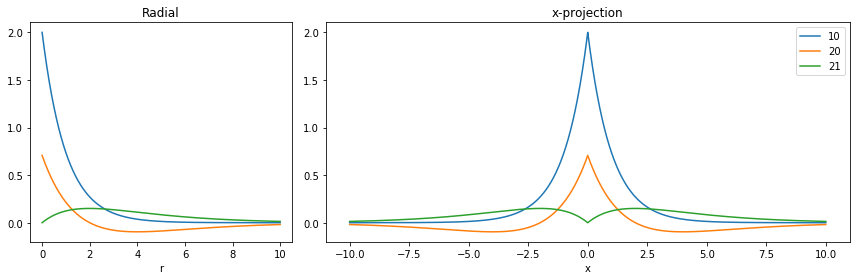

In [331]:
params = array([[1,0],[2,0],[2,1]]) # Can modify if you like, it is a list of [n,l]

r = linspace(0,10,1001)

def H_orb(n,l):
    return sqrt((2/n)**3 * (factorial(n-l-1)) / (2 * n * factorial(n+l)**3)) \
    * exp(-r/n) \
    * ((2*r)/n)**l \
    * assoc_laguerre((2*r/n), (n-l-1), (2*l + 1)) * factorial(n+l)

fig = plt.figure(figsize=(12, 4)) # Set up the plot
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.set_title("Radial")
ax1.set_xlabel("r")

ax2.set_title("x-projection")
ax2.set_xlabel("x")

for p in params:
    R = H_orb(p[0], p[1])
    ax1.plot(r,R)    
    ax2.plot(append(-r[1:][::-1], r), append(R[1:][::-1], R), label = str(p[0])+str(p[1]))
    
ax2.legend()

plt.tight_layout()

But this form is very involved, and is only for hydrogen. An approximation to make calculations easier is known as the slater orbitals, and it argues that you can reasonably approximate a linear combination of the above orbitals (hydrogen-like) with linear combinations of the form 

$$ \Phi(r) = \big( \frac{Z^3}{\pi} \big)^{\frac12} e^{-Zr} $$

which is the same shape as the 1s orbital. However, this is hard to integrate, and so this form is then approximated to a linear combination of gaussians of the form 

$$ \Phi(r) = \big( \frac{2 \alpha}{\pi} \big)^{\frac34} e^{- \alpha r^2} $$

with coefficients that can be found online. This makes calculations easier, but less accurate.

See the difference on hydrogen 1s below for an approximation using 1, 2, and 3 gaussians.

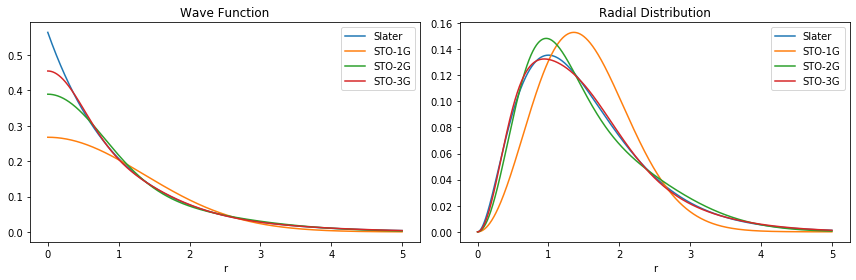

In [606]:
def STONG(r, coeffs):
    R = 0*r
    for ac in coeffs:
        R += ac[1] * (2*ac[0]/pi)**.75 * exp(-ac[0] * r * r)
    return R

r = linspace(0,5,1001)

Slater = (1/pi)**.5 * exp(-r)
Gauss1 = STONG(r, array([[0.270950, 1]]))
Gauss2 = STONG(r, array([[0.151623, 0.678914], [0.851819, 0.430129]]))
Gauss3 = STONG(r, array([[.109818, .444635],[.405771, .535328],[2.22766, .154329]]))

fig = plt.figure(figsize=(12, 4)) # Set up the plot
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

ax1.plot(r, Slater, label="Slater")
ax1.plot(r, Gauss1, label = "STO-1G")
ax1.plot(r, Gauss2, label = "STO-2G")
ax1.plot(r, Gauss3, label = "STO-3G")
ax1.legend()
ax1.set_xlabel("r");
ax1.set_title("Wave Function")

ax2.plot(r, Slater * Slater * pi * r**2, label="Slater")
ax2.plot(r, Gauss1 * Gauss1 * pi * r**2, label = "STO-1G")
ax2.plot(r, Gauss2 * Gauss2 * pi * r**2, label = "STO-2G")
ax2.plot(r, Gauss3 * Gauss3 * pi * r**2, label = "STO-3G")
ax2.legend()
ax2.set_xlabel("r");
ax2.set_title("Radial Distribution")

plt.tight_layout()

So, we know the operations, and we know how orbitals are approximated, so lets get down to actaully solving simple 2 electron systems.

First we need to figure out the form of the fock operator mentioned above.

$$ f(i) = h(i) + v^\mathrm{HF}(i) =- \frac12 \nabla_i^2 - \sum_{A = 1}^M \frac{Z_A}{r_{iA}} + v^\mathrm{HF}(i)   $$

The last term is a term that represents the two-electron repulsion potential as an average 1-electron potential caused by all other electrons, and has a coulomb operator $\mathscr{J}$ and an exchange operator $\mathscr{K}$

$$ \mathscr{J}_b (1) \chi_a (1)= \langle \chi_b (2) | r_{12}^{-1} | \chi_b (2) \rangle \chi_a (1) = \big[ \int | \chi_b (2) |^2 r_{12}^{-1} d\mathbf{x}_2 \big] \chi_a (1) $$

$$ \mathscr{K}_b (1) \chi_a (1) = \langle \chi_b (2) | r_{12}^{-1} | \chi_a (2) \rangle \chi_b (1) = \big[ \int \chi_b^* (2) r_{12}^{-1} \chi_a (2) d\mathbf{x}_2 \big] \chi_b (1) $$

Where $\mathscr{J}_b (1)$ essentially gives the average potential on electron 1 from the averaged position and spin of an electron 2 in a specific spin orbital, and $ \mathscr{K}_b (1) $ has no intuitive understanding and lets just say it is a correction for how the wavefunction changes sign when you swap electrons.

These two operators combined get you the average potential of an electron from all other electrons in the system, and expand the fock operator as follows.

$$ f(1) = h(1) + v^\mathrm{HF}(1) = - \frac12 \nabla_1^2 - \sum_{A} \frac{Z_A}{r_{1a}} + \sum_{b \neq a} \mathscr{J}_b (1) - \sum_{b \neq a} \mathscr{K}_b (1)   $$

making our new eigenvalue problem

$$ \big[ h(1) + \sum_{b \neq a} \mathscr{J}_b (1) - \sum_{b \neq a} \mathscr{K}_b (1) \big] \chi_a (1) = \epsilon_a \chi_a (1)  $$

which can actually be cleaned up a bit to...

$$ f \chi_a = \epsilon_a \chi_a  $$

$$ f(1) = h(1) + \sum_{b} (\mathscr{J}_b (1) - \mathscr{K}_b (1)) = h(1) + v^\mathrm{HF}(1) $$


Derivations of these can be found in Szabo and Ostlund chapter 3.2, and the process is quite involved and I'd rather not recreate it. But this is the bare minimum knowledge we need to continue.


Now, I am gonna reference Szabo ad Ostlund 3.4.1's derivation for transfroming the spin orbital calculation into a calculation involving closed shell restricted spin orbitals, which means that the spin up and spin down spin orbitals for an orbital have the same spatial form, and that the system must have an even number of electrons. It is another approximation, but will be useful for us, as it means we will not have to account for spin inside of each orbital, meaning we only have to integrate over space, and it is functionally similar to the spin orbital derivation, just with some slight tweaks.

Our new fock operator becomes

$$ f(1) = h(1) + \sum_a^{N/2} 2 J_a(1) - K_a(1) $$

where the lack of a 2 in front of the exchange operator in the fock operator is caused by spin orthogonality making one of the 2 terms in an expansion 0 (Check the derivation if you don't belive me, it is a LOT to write in Markdown).

$$ J_a(1) = \int \Psi_a^*(2) r_{12}^{-1} \Psi_a(2) d\mathbf{r}_2 $$

$$ K_a(1) \Psi_i(1) = \big[ \int \Psi_a^*(2) r_{12}^{-1} \Psi_i(2) d\mathbf{r}_2 \big] \Psi_a(1) $$

and we get to keep the eigenvalue problem in the smae functional form of

$$ f(1) \Psi_a(1) = \epsilon_a \Psi_a(1)  $$

and to find the energy of the system, we simple take the wavefunction as a slater determinant of the spatial orbitals multiplied by generic spin functions $ | \mathbf{\Psi}_0 \rangle = | \psi_1 \bar{\psi}_1 ... \psi_a \bar{\psi}_a ... \psi_{N/2} \bar{\psi}_{N/2} \rangle $

$$ E_0 = \langle \mathbf{\Psi}_0 | \mathscr{H} | \mathbf{\Psi}_0 \rangle = 2 \sum_a h_{aa} + \sum_a \sum_b 2 J_{ab} - K_{ab}  $$

$$ h_{aa} = \int \psi_a^*(\mathbf{r}_1) h(\mathbf{r}_1) \psi_a(\mathbf{r}_1) d \mathbf{r}_1 $$

$$ J_{ab} = \int \psi_a^*(\mathbf{r}_1) \psi_a(\mathbf{r}_1) r_{12}^{-1} \psi_b^*(\mathbf{r}_1) \psi_b(\mathbf{r}_1) d \mathbf{r}_1 d \mathbf{r}_2 $$

$$ K_{ab} = \int \psi_a^*(\mathbf{r}_1) \psi_b(\mathbf{r}_1) r_{12}^{-1} \psi_b^*(\mathbf{r}_1) \psi_a(\mathbf{r}_1) d \mathbf{r}_1 d \mathbf{r}_2 $$

Now, the background is getting pretty long now, so I will skip the process of the Roothaan Equations, but I will tell you that they essentially define an iterative system of matrix problems that converge onto the correct atomic/molecular orbitals for the groundstate, and they can be compactly written as 

$$ \mathbf{FC} = \mathbf{SC \epsilon} $$

where $\mathbf{F}$ is the fock matrix, used for getting the energies of the orbitals, which are represented by the columns of $\mathbf{C}$. $\mathbf{S}$ is an overlap matrix, and $\mathbf{\epsilon}$ is a diganol matrix with all of the calculated orbital energies. You can calculate the correct $\mathbf{C}$ matrix by iteratively solving parts of this equation, and repeating until it stops changing. Szabo and Ostlund page 146 gives a clear step by step procedure.

I will know define some functions that we will need for the calculations. Ideally I would define them later for the purpose of this being a tutorial, but loading in functions unnecessarilly is bad coding practice. These will mainly be integrals that are defined and described in Appendix A of Szabo and Ostlund (what a great book) I also have made the executive decision of diagnolizing matrices using numpy functions. The matrices need here can actually be diagnolized through a specific pattern as they will be 2x2, but I want to generalize as much as possible and there are always great libraries around for diagnolization and genralized functions (like the error function), so use them if you can.

## Integral Calculations

In [333]:
# this calculates the F0 function, but for only s-type orbitals (l = 0) hence F0
def F0(t):
    if t < 1.0e-6: # Something to stop divide by 0 errors
        return 1.0 - t/3.0
    else:
        return 0.5 * sqrt(pi/t) * erf(sqrt(t))

# I will be representing gaussians with A0[0] being the orbital coefficiant and A0[1] being it's normalization constant

# Solves for uv element in the overlap matrix
def Sab(Aa, Ab, Rab2):
    '''
    Solves for ab element in the overlap matrix
    A# is the orbital exponent and weight of the gaussian centered on atom # 
    Rab2 is the square of the distance between the two atoms
    '''
    a = Aa[0]
    b = Ab[0]
    return (pi/(a+b))**(1.5) * exp(-a*b*Rab2/(a+b)) * Aa[1] * Ab[1]

# Solves for uv element in the kinetic energy matrix
def Tab(Aa, Ab, Rab2):
    '''
    Solves for ab element in the kinetic energy matrix
    A# is the orbital exponent and weight of the gaussian centered on atom # 
    Rav2 is the square of the distance between the two atoms
    '''
    a = Aa[0]
    b = Ab[0]
    return (a*b/(a+b)) * (3-2*a*b*Rab2/(a+b)) * (pi/(a+b))**1.5 * exp(-a*b*Rab2/(a+b)) * Aa[1] * Ab[1]

# Solves for uv element in the Electron-Nuclear attraction potential matrix
def Vab(Aa, Ab, Rab2, Rpc2, Zc):
    '''
    Solves for ab element in the Electron-Nuclear attraction potential matrix
    A# is the orbital exponent and weight of the gaussian centered on atom # 
    Rab2 is the square of the distance between the two atoms
    Rpc2 is the square of the distance between the "center" of the gaussians when multipled and the nucleus of interest
    Zc is the charge of the nucleus
    '''
    a = Aa[0]
    b = Ab[0]
    return (-2*pi/(a+b)) * Zc * exp(-a*b*Rab2/(a+b)) * F0((a+b)*Rpc2) * Aa[1] * Ab[1]


# Solves for abcd element in the 2 electron integral tensor
def twoe(Aa, Ab, Ac, Ad, Rab2, Rcd2, Rpq2):
    '''
    Solves for ab element in the Electron-Nuclear attraction potential matrix
    A# is the orbital exponent and weight of the gaussian centered on atom # 
    Rab2/Rcd2 is the square of the distance between the two atoms
    Rpq2 is the square of the distance between the "centers" of the gaussians when multiplied
    Zc is the charge of the nucleus
    '''
    a = Aa[0]
    b = Ab[0]
    c = Ac[0]
    d = Ad[0]
    return 2*pi**2.5 / ((a+b)*(c+d)*(a+b+c+d)**0.5) \
* exp(-a*b*Rab2/(a+b) - c*d*Rcd2/(c+d)) \
* F0((a+b)*(c+d)*Rpq2/(a+b+c+d)) \
* Aa[1] * Ab[1] * Ac[1] * Ad[1]

## One Electron Matrix Generation

In [465]:
# generates a diaganol matrix from an array
def gen_diag(v):
    D = zeros((len(v), len(v)))
    for i in range(len(v)):
        D[i][i] += v[i]
    return D

def oneemats(A1, A2, R, ZA, ZB, prnt=False):
    # initialize matrices for overlap, kinetic, and potential integrals
    Smat = gen_diag(ones(nel))
    Tmat = zeros((nel,nel))
    Vmat = zeros((nel,nel))

    # Calculate the one-electron integrals: -> overlap, kinetic, and potential 
    # center A is the first atom, center B the second -> origin is on A
    # sum over all N-indices for each atom
    n = len(A1[:])
    R2 = R*R
    for i in range(n):
        for j in range(n):
            RAP = A2[j,0]*R/(A1[i,0] + A2[j,0])
            # RAP2 is squared distance between center A and center P, etc. 
            RAP2 = RAP**2
            RBP2 = (R - RAP)**2
            
            Smat[0,1]  += Sab(A1[i], A2[j], R2)

            Tmat[0,0] += Tab(A1[i], A1[j], 0.0)
            Tmat[0,1] += Tab(A1[i], A2[j],  R2)
            Tmat[1,1] += Tab(A2[i], A2[j], 0.0)

            # Potential from atom A + potential from atom B 
            Vmat[0,0] += Vab(A1[i], A1[j], 0.0, 0.0, ZA)
            Vmat[0,0] += Vab(A1[i], A1[j], 0.0,  R2, ZB)

            # off-diagonal nuclear attraction to center A, etc.
            Vmat[0,1] += Vab(A1[i], A2[j], R2, RAP2, ZA)
            Vmat[0,1] += Vab(A1[i], A2[j], R2, RBP2, ZB)
            
            Vmat[1,1] += Vab(A2[i], A2[j], 0.0,  R2, ZA)
            Vmat[1,1] += Vab(A2[i], A2[j], 0.0, 0.0, ZB)
    
    # note the symmetry, the lower off-diagonal elements are equal to the upper off-diagonal elements
    Smat[1,0] = Smat[0,1]
    Tmat[1,0] = Tmat[0,1]
    Vmat[1,0] = Vmat[0,1]

    # create the core hamiltonian, H = T + V
    Hmat = Tmat + Vmat 
    
    if prnt:
        print_matrix(Smat, 'Smat')
        print_matrix(Tmat, 'Tmat')
        print_matrix(Vmat, 'Vmat')
        print_matrix(Hmat, 'Hmat')
    
    return Smat, Hmat
    

## 2 Electron Tensor (SPECIFIC FOR 2 ELECTRON SYSTEMS, NOT GENERALIZED)

In [509]:
def twoemats(A1, A2, R, prnt=False):

    Vee = zeros((nel,nel,nel,nel))

    n = len(A1[:])
    R2 = R*R

    for i in range(0, n):
        for j in range(0, n):
            for k in range(0, n):
                for l in range(0, n):
                    # compute R distances for each center
                    RAP = A2[i,0]*R/(A1[j,0] + A2[i,0])
                    RBP = R - RAP
                    RAQ = A2[k,0]*R/(A1[l,0] + A2[k,0])
                    RBQ = R - RAQ
                    RPQ = RAP - RAQ
                    
                    Vee[0,0,0,0] += twoe(A1[i], A1[j], A1[k], A1[l], 0.0, 0.0,    0.0)
                    Vee[1,0,0,0] += twoe(A2[i], A1[j], A1[k], A1[l],  R2, 0.0, RAP**2)
                    Vee[1,0,1,0] += twoe(A2[i], A1[j], A2[k], A1[l],  R2,  R2, RPQ**2)
                    Vee[1,1,0,0] += twoe(A2[i], A2[j], A1[k], A1[l], 0.0, 0.0,     R2)
                    Vee[1,1,1,0] += twoe(A2[i], A2[j], A2[k], A1[l], 0.0,  R2, RBQ**2)
                    Vee[1,1,1,1] += twoe(A2[i], A2[j], A2[k], A2[l], 0.0, 0.0,    0.0)

    # Fill the rest of the tensor using symmetry relations 
    Vee[0,1,0,0] = Vee[1,0,0,0] 
    Vee[0,0,1,0] = Vee[1,0,0,0] 
    Vee[0,0,0,1] = Vee[1,0,0,0]
    Vee[0,1,1,0] = Vee[1,0,1,0]
    Vee[1,0,0,1] = Vee[1,0,1,0]
    Vee[0,1,0,1] = Vee[1,0,1,0]
    Vee[0,0,1,1] = Vee[1,1,0,0]
    Vee[1,1,0,1] = Vee[1,1,1,0]
    Vee[1,0,1,1] = Vee[1,1,1,0]
    Vee[0,1,1,1] = Vee[1,1,1,0]

    if prnt:
        print('0 0 0 0  {: 15.10f}'.format(Vee[0,0,0,0]))
        print('1 0 0 0  {: 15.10f}'.format(Vee[1,0,0,0]))
        print('0 1 0 0  {: 15.10f}'.format(Vee[0,1,0,0]))
        print('0 0 1 0  {: 15.10f}'.format(Vee[0,0,1,0]))
        print('0 0 0 1  {: 15.10f}'.format(Vee[0,0,0,1]))
        print('1 0 1 0  {: 15.10f}'.format(Vee[1,0,1,0]))
        print('1 0 0 1  {: 15.10f}'.format(Vee[1,0,0,1]))
        print('0 1 1 0  {: 15.10f}'.format(Vee[0,1,1,0]))
        print('0 1 0 1  {: 15.10f}'.format(Vee[0,1,0,1]))
        print('1 1 0 0  {: 15.10f}'.format(Vee[1,1,0,0]))
        print('0 0 1 1  {: 15.10f}'.format(Vee[0,0,1,1]))
        print('1 1 1 0  {: 15.10f}'.format(Vee[1,1,1,0]))
        print('1 1 0 1  {: 15.10f}'.format(Vee[1,1,0,1]))
        print('1 0 1 1  {: 15.10f}'.format(Vee[1,0,1,1]))
        print('0 1 1 1  {: 15.10f}'.format(Vee[0,1,1,1]))
        print('1 1 1 1  {: 15.10f}\n'.format(Vee[1,1,1,1]))
        
    return Vee

## G Matrix (Something I never mentioned. Think of it as the changing part of the Fock matrix) and X matrix

In [613]:
def formG(P, Vee):
    '''P is the density matrix'''
    G = zeros((nel,nel))
    for i in range(nel):
        for j in range(nel):
            for k in range(nel):
                for l in range(nel):
                    # Coulomb integral -> J
                    G[i,j] += P[k,l]*Vee[i,j,l,k]
                    # exchange integral -> K
                    G[i,j] -= 0.5*P[k,l]*Vee[i,l,k,j]
    return G

def formX(S): # Also could be used as a general dignolization script if all eigenvalues are positive
    '''S is the overlap matrix'''
    w,v = eigh(S)
    for i in range(len(v)):
        v[:,i] = v[:,i]/sqrt(w[i])
    return v    

## Definition of Basis Sets

In [614]:
def gen_bs(zeta1, zeta2, N):

    # these are the coefficients and exponents of the STO-NG bases
    # the exponents turn into the STO-NG basis sets for the respective
    # atom when multiplied by the appropriate zeta
    coeff_sto = array([
        [1.000000, 0.000000, 0.000000], # STO-1G coeff
        [0.678914, 0.430129, 0.000000], # STO-2G coeff
        [0.444635, 0.535328, 0.154329], # STO-3G coeff
    ])

    expon_sto = array([
        [0.270950, 0.000000, 0.000000], # STO-1G expon
        [0.151623, 0.851819, 0.000000], # STO-2G expon
        [0.109818, 0.405771, 2.227660], # STO-3G expon
    ])

    # here we scale the basis coeffs and exponents suitable for each Z
    # we are using the STO-3G basis, which is the third row (row index = 2) so we use n to take all N columns
    # remember numpy arrays can be operated on like normal numbers, i.e. w/o for loops

    n=N-1

    # Atom 1
    A1 = zeros((N,2))
    A1[:,0] += expon_sto[n,0:N]*(zeta1**2)
    A1[:,1] += coeff_sto[n,0:N]*((2.0*A1[:,0]/pi)**0.75)

    # Atom 2
    A2 = zeros((N,2))
    A2[:,0] += expon_sto[n,0:N]*(zeta2**2)
    A2[:,1] += coeff_sto[n,0:N]*((2.0*A2[:,0]/pi)**0.75)

    # A1[:][0] has the orbital exponents for atom 1
    # A1[:][1] has the contraction coefficients for atom 1
    # in terms of unnormalized primitive gaussians

    return A1, A2

# WE CAN FINALLY MOVE ONTO THE ACTUAL SCF ITERATION!

#### SCF Iteration
Before starting:

- Compute $\mathbf{S}$, $\mathbf{H}$, and initial two electron integrals

- Get the transformation matrix $\mathbf{X}$ from diagonolizing $\mathbf{S}$

- Get an initial guess for $\mathbf{P}$

for each iteration do:
1. Build Fock matrix
    - Build the $\mathbf{G}$ matrix from the Coulomb and Exchange terms
    - Form the Fock matrix $\mathbf{F}$
2. RHF Energy (Not necessary, but we can do it so might as well.)
    - Compute electronic RHF energy
    - Compute total RHF energy
3. Compute new orbital guess
    - Transform Fock matrix to orthonormal AO basis $\mathbf{F}'$ with $\mathbf{X}$ 
    - Diagonalize $\mathbf{F}'$ for $\varepsilon$ and $\mathbf{C}'$
    - Back transform $\mathbf{C}'$ to AO basis
    - Form $\mathbf{P}$ from occupied orbital slice of $\mathbf{C}$
4. Check change in density matrix
    - Compare the change in $\mathbf{P}$ from the prior run
    - If threshold is reached exit loop
    - Else keep going 

In [615]:
def scf(S, H, Vee, Crit = 1.0e-4, MaxIt = 25, filename="scf.out", prnt=False, grabit=False):
    # this is our initial guess of the density matrix -> a bunch of zeros
    P = zeros((nel,nel))

    # create the X matrix
    X = formX(S)

    # open the output file for writing 
    f = open(filename, 'w')

    # print out the initial density matrix to the outfile 
    print_matrix(P, 'P matrix', print_file=f)

    # go through the iterations 
    for scf_iter in range(MaxIt):

        # make the G matrix from the P matrix
        G = formG(P, Vee)

        # Update the fock matrix
        F = H + G

        # compute the electronic energy and the total energy
        E = 0
        for i in range(len(F)):
            for j in range(len(F[0])):
                E += P[j,i] * (H[i,j] + F[i,j])
        E /= 2

        # Total energy = electronic energy + nuclear repulsion energy
        ET = E + E_nuc

        # Get F' = X^T * F * X
        Fp = matmul(conj(X).T, matmul(F, X))

        # C' is the matrix of eigenvectors from the diagonalization, epsilon is the array of eigenvalues
        eps, Cp = eigh(Fp)

        # Get C = X * C' 
        C = matmul(X,Cp)

        # copy the density matrix from the previous iteration
        oldP = P.copy()

        # compute a new P
        P = P*0
        for i in range(len(P)):
            for j in range(len(P[0])):
                for a in range(int(nel/2)):
                    P[i,j] +=  2* ( C[i,a] * conj(C[j,a]) )
                    

        # see how much the new density matrix has changed from the previous one
        delta = sqrt(sum((P - oldP)**2))/len(P)
        if prnt:
            print('SCF Iteration {:2d}: Energy = {: 4.12f} dP = {: 1.5e}'.format(scf_iter+1, ET, delta))

        # print info to file
        verbose_iter_print(f, scf_iter, F, Fp, C, Cp, P, E, ET, delta)

        # check the convergence criteria, if delta reaches the threshold the loop will exit, else it continues
        if delta <= Crit:
            break

    # the loop has exited, determine why
    # if delta is above threshold and max iterations are reached -> convergence failed
    if delta > Crit and scf_iter == MaxIt:
        print_error_quit()
        
    # if not -> convergence succeeded!
    else:
        print_convergence_success(eps, f, E, ET)

    # close the file
    f.close()
    # print the energies to the screen 
    if prnt:
        print('Electronic Energy  = {: .12f}'.format(E))
        print('Total Energy       = {: .12f}'.format(ET))
    # store the energy value for comparison 
    if grabit:
        return E, ET, G, F, Fp, eps, Cp, C, P
    else:
        return ET
    
def scf_no_output(S, H, Vee, Crit = 1.0e-4, MaxIt = 25, grabit=False):
    # this is our initial guess of the density matrix -> a bunch of zeros
    P = zeros((nel,nel))

    # create the X matrix
    X = formX(S)

    # go through the iterations 
    for scf_iter in range(MaxIt):

        # make the G matrix from the P matrix
        G = formG(P, Vee)

        # Update the fock matrix
        F = H + G

        # compute the electronic energy and the total energy
        E = 0
        for i in range(len(F)):
            for j in range(len(F[0])):
                E += P[j,i] * (H[i,j] + F[i,j])
        E /= 2

        # Total energy = electronic energy + nuclear repulsion energy
        ET = E + E_nuc

        # Get F' = X^T * F * X
        Fp = matmul(conj(X).T, matmul(F, X))

        # C' is the matrix of eigenvectors from the diagonalization, epsilon is the array of eigenvalues
        eps, Cp = eigh(Fp)


        # Get C = X * C' 
        C = matmul(X,Cp)

        # copy the density matrix from the previous iteration
        oldP = P.copy()

        # compute a new P
        P = P*0
        for i in range(len(P)):
            for j in range(len(P[0])):
                for a in range(int(nel/2)):
                    P[i,j] +=  2*( C[i,a] * conj(C[j,a]) )

        # see how much the new density matrix has changed from the previous one
        delta = sqrt(sum((P - oldP)**2))/len(P)

        # check the convergence criteria, if delta reaches the threshold the loop will exit, else it continues
        if delta <= Crit:
            break
    if grabit:
        return E, ET, G, F, Fp, eps, Cp, C, P
    else:
        return ET

# With that out of the way, we can now set our parameters and solve for the energy of systems! To showcase this, I will do some dissociation curves on different basis sets.

In [616]:
rvals = linspace(0.7, 6, 101)
Es = zeros((3,len(rvals)))

nel = 2          # number of electrons DO NOT CHANGE
ZA = 2.0         # Atomic number for He
ZB = 1.0         # Atomic number for H
zeta1 = 2 # 2.0925
zeta2 = 1 # 1.24

for N in range(1,4):
    for i in range(len(rvals)):
        # STO-NG calc for N = 1, 2 or 3 basis functions.

        R = rvals[i]
        R2 = R*R         # the distance squared

        # Define nuclear repulsion energy -> it will not change throughout scf cycle 
        E_nuc = ZA*ZB/R

        A1, A2 = gen_bs(zeta1, zeta2, N)

        S, H = oneemats(A1, A2, R, ZA, ZB, prnt=False)

        Vee = twoemats(A1, A2, R, prnt=False)
        
        Es[N-1][i] = scf_no_output(S, H, Vee)

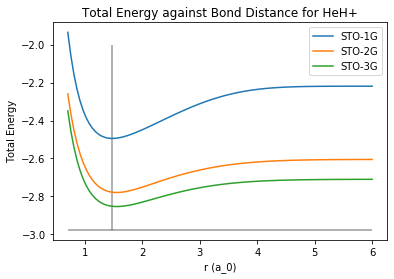

In [617]:
plt.plot(rvals, Es[0], label=("STO-1G"))
plt.plot(rvals, Es[1], label=("STO-2G"))
plt.plot(rvals, Es[2], label=("STO-3G"))
plt.legend()
plt.xlabel('r (a_0)')
plt.ylabel("Total Energy")
plt.hlines(-2.977537, 0.7,6, alpha=0.4)
plt.vlines(1.462648, -2.977537, -2, alpha=.4)
plt.title("Total Energy against Bond Distance for HeH+");

## The grey lines represented the actual ideal bond distance and minimum energy, and it can be seen that we stray quite a bit. HOWEVER, this method is fast, and our minimum energy of ~ -2.8533279 is actually accounting for 95.83% of the systems total energy, and we get a equilibrium distance of ~1.601, which is only 0.14 too long. Which isn't too shabby if you ask me.

## But wait. If we adjust our zetas to be 2.0925 and 1.24, we can reduce our energy further to ~ -2.862809, which is 96.15% of the systems total energy, and we get an equilibrium distance of 1.389, which is only 0.07 short of the actual answer!

Below is an example of a printed output.

In [618]:
nel = 2          # number of electrons DO NOT CHANGE
ZA = 2.0         # Atomic number for He
ZB = 1.0         # Atomic number for H

R = 1.4632
R2 = R*R         # the distance squared

N = 3

# Define nuclear repulsion energy -> it will not change throughout scf cycle 
E_nuc = ZA*ZB/R

A1, A2 = gen_bs(2.0925, 1.24, N)

S, H = oneemats(A1, A2, R, ZA, ZB, prnt=True)

Vee = twoemats(A1, A2, R, prnt=True)

E, ET, G, F, Fp, eps, Cp, C, P = scf(S, H, Vee, Crit = 1.0e-4, MaxIt = 25, filename="scf.out", prnt=True, grabit=True)

        Smat        
 1.000000  0.450770
 0.450770  1.000000

        Tmat        
 2.164313  0.167013
 0.167013  0.760033

        Vmat        
-4.817057 -1.514218
-1.514218 -2.491861

        Hmat        
-2.652745 -1.347205
-1.347205 -1.731828

0 0 0 0     1.3071516076
1 0 0 0     0.4372793253
0 1 0 0     0.4372793253
0 0 1 0     0.4372793253
0 0 0 1     0.4372793253
1 0 1 0     0.1772671220
1 0 0 1     0.1772671220
0 1 1 0     0.1772671220
0 1 0 1     0.1772671220
1 1 0 0     0.6057033663
0 0 1 1     0.6057033663
1 1 1 0     0.3117945704
1 1 0 1     0.3117945704
1 0 1 1     0.3117945704
0 1 1 1     0.3117945704
1 1 1 1     0.7746083600

SCF Iteration  1: Energy =  1.366867140514 dP =  8.82867e-01
SCF Iteration  2: Energy = -2.774995735620 dP =  2.79176e-01
SCF Iteration  3: Energy = -2.859624758615 dP =  2.96618e-02
SCF Iteration  4: Energy = -2.860655784830 dP =  2.31828e-03
SCF Iteration  5: Energy = -2.860662127586 dP =  1.74398e-04
SCF Iteration  6: Energy = -2.860662163500 dP 

In [619]:
# uncomment and run cell, there will be a lot 
results = open('scf.out','r')
for j in results.readlines():
    print(j)
results.close()

      P matrix      

 0.000000  0.000000

 0.000000  0.000000





********************************* Iteration  1 *********************************



     F matrix                   F' matrix      

-2.652745 -1.347205         -1.538667  0.515839

-1.347205 -1.731828          0.515839 -2.439733



     C matrix                   C' matrix      

 0.929147  0.625857         -0.413630 -0.910445

 0.139833 -1.111511          0.910445 -0.413630



                    P matrix                     

                1.726627  0.259851               

                0.259851  0.039107               



Electronic Energy    =  0.00000000000

Total Energy         =  1.36686714051

Delta (Convergence of the density matrix) = 8.828669e-01



********************************* Iteration  2 *********************************



     F matrix                   F' matrix      

-1.390415 -0.973201         -0.170136  0.362710

-0.973201 -0.742875          0.362710 -1.406043



     C matrix           

# Visualization

## What did the intial choice of AOs look like?

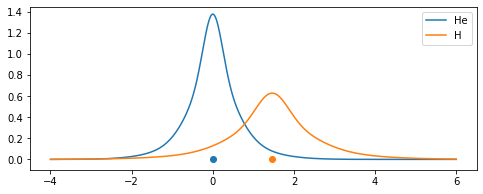

In [620]:
r = linspace(-4,6,1001)

AO1 = r*0
for params in A1:
    AO1 += params[1]*exp(-params[0]*r**2)
    
AO2 = r*0
for params in A2:
    AO2 += params[1]*exp(-params[0]*(r-R)**2)
    
plt.figure(figsize=(8,3))
plt.plot(r, AO1, label="He")
plt.plot(r, AO2, label="H")
plt.scatter(0,0)
plt.scatter(R,0)
plt.legend();

## Which have electronic probability distributions along their bond as seen below

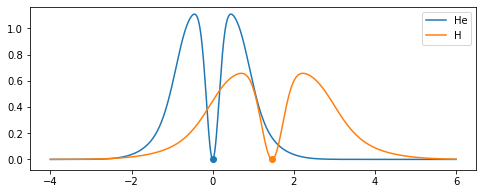

In [621]:
plt.figure(figsize=(8,3))
plt.plot(r, AO1*AO1*4*pi*r**2, label="He")
plt.plot(r, AO2*AO2*4*pi*(r-R)**2, label="H")
plt.scatter(0,0)
plt.scatter(R,0)
plt.legend();

## If we project the components contributed from x and y onto the z-axis, which will be the bond, we can make the math easier and also apply it easilly to the molecular orbitals because I realize I now should have done this is general coordinates, even if it made more variables. Oh well.

## The following is the distribution, for a specific z and unspecific x and y. We can assume it is localized around z, but we cannot say what the actual value is for specific x and y given the information below. Think of this as being a slice of the distribution if it was modeled cylindrically

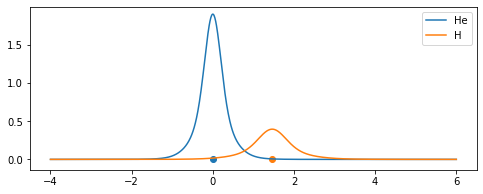

In [622]:
plt.figure(figsize=(8,3))
plt.plot(r, AO1*AO1, label="He")
plt.plot(r, AO2*AO2, label="H")
plt.scatter(0,0)
plt.scatter(R,0)
plt.legend();

### For the above, all we know is that there are two electrons in the system. They could both be on He, both on H, or one in each state. This is just the inital guess though, and it is unimportant.

## The final, molecular orbitals look like this.

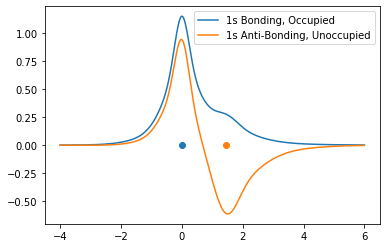

In [623]:
MO1 = C[0,0]*AO1 + C[1,0]*AO2
MO2 = C[0,1]*AO1 + C[1,1]*AO2

plt.scatter(0,0)
plt.scatter(R,0)
plt.plot(r,MO1, label="1s Bonding, Occupied")
plt.plot(r,MO2, label="1s Anti-Bonding, Unoccupied");

plt.legend();

## Only the first molecular orbital is occupied, since this is the ground state, but the distribution for z and a generic x,y, centered around the bond looks like the blue line below. If we had 4 electrons in the system, the faint orange line would be the 2 extra electrons distribution.

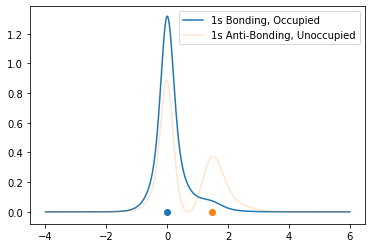

In [624]:
plt.scatter(0,0)
plt.scatter(R,0)
plt.plot(r,MO1*MO1, label="1s Bonding, Occupied")
plt.plot(r,MO2*MO2, label="1s Anti-Bonding, Unoccupied", alpha=0.2);

plt.legend();